In [15]:
import glob
import logging
import random
import time
import gc

import numpy as np
import matplotlib.pyplot as plt

import cv2
import torchstain

import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations as A
from albumentations.pytorch import ToTensorV2


from patch_dataset import SlideROIDataset
from train_utils import run_train_loop, seed_worker, plot_history
from extract_patches import create_bbox_list
from log_utils import setup_logging

In [2]:
setup_logging()

2023-08-20 21:43:14,617-INFO-Logging setup complete.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"pytorch device using: {device}")

2023-08-20 21:43:15,513-INFO-pytorch device using: cuda


In [4]:
THUMB_PATH = './data/thumbnail_patches'

# relative to script execution path
OUTPUT_PLOT_PATH = "./output/plots"
MODEL_SAVEPATH = "./models"

In [5]:
# load dataset
train_slide_feat_paths = sorted(glob.glob(f"{THUMB_PATH}/train/**"))

train_img_path = []
train_roi_path = []

for slide_feat in train_slide_feat_paths:
    train_img_path.extend(glob.glob(slide_feat + "/patch/*.png"))
    train_roi_path.extend(glob.glob(slide_feat + "/roi/*.npy"))

train_img_path.sort()
train_roi_path.sort()

assert len(train_img_path) == len(train_roi_path), "Number of images and rois should be equal"

logging.info(f"Number of train images: {len(train_img_path)}")

val_slide_feat_paths = sorted(glob.glob(f"{THUMB_PATH}/val/**"))

val_img_path = []
val_roi_path = []

for slide_feat in val_slide_feat_paths:
    val_img_path.extend(glob.glob(slide_feat + "/patch/*.png"))
    val_roi_path.extend(glob.glob(slide_feat + "/roi/*.npy"))

val_img_path.sort()
val_roi_path.sort()

assert len(val_img_path) == len(val_roi_path), "Number of images and rois should be equal"

logging.info(f"Number of val images: {len(val_img_path)}")

2023-08-20 21:43:15,755-INFO-Number of train images: 16695
2023-08-20 21:43:15,775-INFO-Number of val images: 2213


In [6]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Rotate([90, 90], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]))

In [7]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

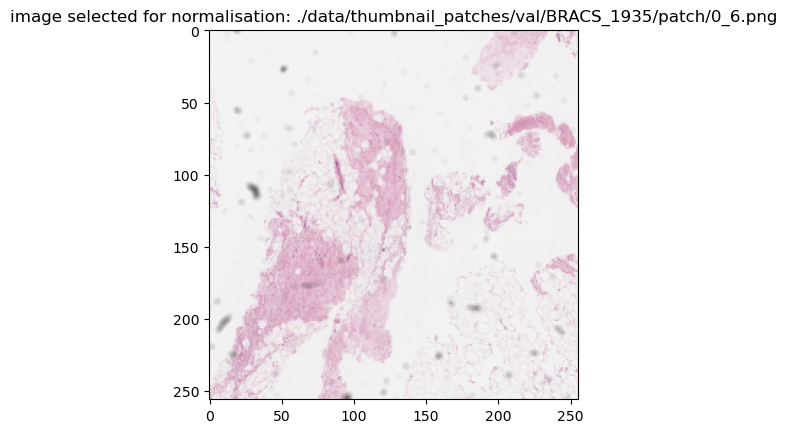

In [8]:
norm_img_path = val_img_path[len(val_img_path)//2]
norm_img_arr = cv2.cvtColor(cv2.imread(norm_img_path), cv2.COLOR_BGR2RGB)
plt.imshow(norm_img_arr)
plt.title(f"image selected for normalisation: {norm_img_path}")
plt.show()

In [9]:
stain_normaliser = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
stain_normaliser.fit(norm_img_arr)

In [10]:
train_dataset = SlideROIDataset(train_img_path, train_roi_path, stain_normaliser=stain_normaliser, transform=train_transform, seed=0)

val_dataset = SlideROIDataset(val_img_path, val_roi_path, stain_normaliser=stain_normaliser, transform=val_transform, seed=0)

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [13]:
torch.cuda.empty_cache()
gc.collect()

9

In [14]:
# define the hyperparameters
LEARNING_RATE = 1e-4
BATCHSIZE = 16
EPOCHS = 10
NUM_WORKERS = 16
PREFETCH_FACTOR = 2

if __name__ == "__main__":
    # dataloaders
    worker_g = torch.Generator()
    worker_g.manual_seed(0)

    train_batches = DataLoader(
        train_dataset, batch_size=BATCHSIZE, shuffle=True,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, collate_fn=collate_fn,
        pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )
    worker_g.manual_seed(0)
    valid_batches = DataLoader(
        val_dataset, batch_size=BATCHSIZE, shuffle=False,
        num_workers=NUM_WORKERS, worker_init_fn=seed_worker, collate_fn=collate_fn,
        pin_memory=True, prefetch_factor=PREFETCH_FACTOR
    )

    # define the loss function and the optimizer
    criterion = torch.nn.CrossEntropyLoss()
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=LEARNING_RATE)

    start_time = time.time()

    set_name = f"fasterrcnn_resnet50_fpn_v2_{EPOCHS}epochs"
    # train the network
    history = run_train_loop(
        model, 2, device,
        train_batches, valid_batches,
        EPOCHS, criterion, optimizer,
        set_name, model_type="detection",
        save_interval=50, save_path=MODEL_SAVEPATH
    )

    # display the total time needed to perform the training
    end_time = time.time()
    logging.info(f"main - Total time taken to train the {set_name} model: {(end_time - start_time):.2f}s")

    # plot the loss and accuracy history
    plot_history(history, save_path=f"{OUTPUT_PLOT_PATH}/{set_name}_history.png")

  0%|          | 8/2087 [10:37<49:15:42, 85.30s/it]

In [ ]:
torch.save(
    {
        "epoch": EPOCHS,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "history": history,
    },
    f"{MODEL_SAVEPATH}/{set_name}_model_final.pth"
)

In [14]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn()

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load(f"./models/fasterrcnn_mobilenet_fpn_10epochs_best_model.pth")["model_state_dict"])

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [82]:
try_val = val_dataset[5]

tensor([101., 249., 150., 256.])
tensor([ 79., 255., 104., 256.])
tensor([225.,  79., 256., 155.])
tensor([182., 112., 236., 180.])
tensor([162., 194., 208., 218.])
tensor([181., 231., 218., 256.])
tensor([207., 210., 256., 256.])
tensor([206., 180., 235., 208.])
[130.00797  80.17292 195.77968 147.5608 ] 0.2691388
[205.92705 198.2289  256.      250.12914] 0.26170167
[163.27953 125.60699 212.9864  186.16068] 0.24934067
[171.32404 231.2847  224.05591 256.     ] 0.14197508
[228.20369 226.76555 256.      256.     ] 0.12709057
[160.48517 174.83636 245.02655 222.77379] 0.11230623
[161.65733 109.73533 234.78108 217.8011 ] 0.09143672
[218.1308   118.076256 256.       169.35164 ] 0.08881362
[158.04951 180.80617 195.85416 222.81082] 0.071158364
[ 28.502455 211.29036  101.661285 256.      ] 0.060649317
[218.84056 152.26465 238.69283 173.4315 ] 0.059879735
[197.29083 134.85884 250.48103 175.94336] 0.056235734


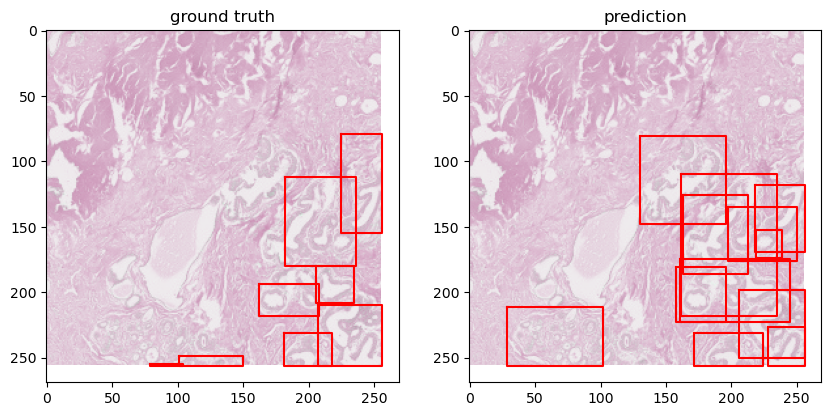

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

try_plot_arr = try_val[0].permute(1, 2, 0).cpu().numpy()
ax[0].imshow(try_plot_arr)
ax[0].set_title("ground truth")
for box in try_val[1]["boxes"]:
    xmin, ymin, xmax, ymax = box
    print(box)
    ax[0].plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color="red")

model.eval()

pred = model(try_val[0].unsqueeze(0).to(device))
try_plot_pred_arr = try_val[0].permute(1, 2, 0).cpu().numpy()

keep = torchvision.ops.nms(pred[0]["boxes"], pred[0]["scores"], 0.4)

ax[1].imshow(try_plot_pred_arr)
ax[1].set_title("prediction")
for box, score in zip(
    pred[0]["boxes"][keep].cpu().detach().numpy(),
    pred[0]["scores"][keep].cpu().detach().numpy()
):
    xmin, ymin, xmax, ymax = box
    # filter out low score boxes and boxes that are too small
    # if score < 0.1 or (xmax - xmin) * (ymax - ymin) < 100:
    #     continue
    print(box, score)
    ax[1].plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color="red")

plt.show()

In [16]:
DATA_PATH = '/mnt/d/UCL-HDS-DissertationDataset/BRACS/BRACS_WSI'
ANNOT_PATH = '/mnt/c/UCL-HDS-DissertationDataset/BRACS_WSI_Annotations'
PATCH_PATH = './data/patches'

In [39]:
import openslide
import geojson


slide = openslide.OpenSlide(f'{DATA_PATH}/train/Group_BT/Type_PB/BRACS_1003668.svs')

print("levels:", slide.level_count)
print("level dimensions", slide.level_dimensions)
print("level downsamples", slide.level_downsamples)

# get annotations
annotation_file = f'{ANNOT_PATH}/train/Group_BT/Type_PB/BRACS_1003668.geojson'
annotations = geojson.load(open(annotation_file))
bbox_list = create_bbox_list(annotations)

levels: 4
level dimensions ((108527, 67936), (27131, 16984), (6782, 4246), (3391, 2123))
level downsamples (1.0, 4.00005528730972, 16.001105868475378, 32.002211736950755)


[652.8051  324.98932 826.5448  510.79703] 0.07191819


[{'boxes': tensor([[652.8051, 324.9893, 826.5448, 510.7970]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.0719], device='cuda:0', grad_fn=<IndexBackward0>)}]

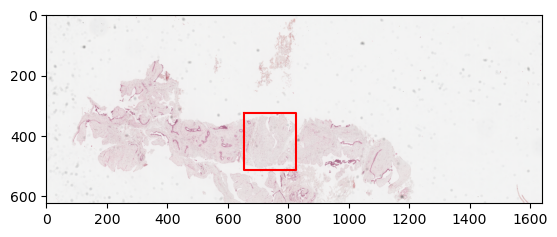

In [51]:
model.eval()

slide_thumbnail = slide.get_thumbnail(slide.level_dimensions[-1])

pred = model(torch.from_numpy(np.array(slide_thumbnail, dtype=np.float32)[1500:,1750:]/255.0).permute(2, 0, 1).unsqueeze(0).to(device))
keep = torchvision.ops.nms(pred[0]["boxes"], pred[0]["scores"], 0.1)

plt.imshow(np.array(slide_thumbnail)[1500:,1750:])
for box, score in zip(
    pred[0]["boxes"][keep].cpu().detach().numpy(),
    pred[0]["scores"][keep].cpu().detach().numpy()
):
    xmin, ymin, xmax, ymax = box
    # filter out low score boxes and boxes that are too small
    # if score < 0.1 or (xmax - xmin) * (ymax - ymin) < 100:
    #     continue
    print(box, score)
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color="red")

pred

In [81]:
(np.array([[1,2,3,4], [5,6,7,8]]).reshape(-1, 2, 2)*np.array([2,3])).reshape(-1, 4)

array([[ 2,  6,  6, 12],
       [10, 18, 14, 24]])

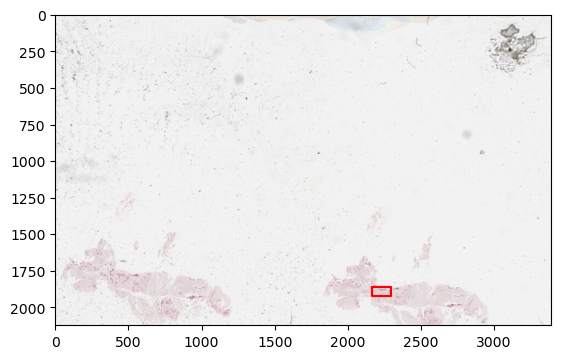

In [48]:
plt.imshow(slide_thumbnail)
for grd_truth in bbox_list:
    (xmin, ymin), (xmax, ymax) = grd_truth["coordinates"]
    scale_factor = np.array(slide.level_dimensions[-1]) / np.array(slide.level_dimensions[0])
    plt.plot(
        np.array([xmin, xmax, xmax, xmin, xmin]) * scale_factor[1],
        np.array([ymin, ymin, ymax, ymax, ymin]) * scale_factor[0],
        color="red"
    )